In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations


[0.0, 0.21599650000000103, 1.174453530000001]
[0.0, 0.8720547700000001, 1.5399565499999994]
[0.0, 0.25031641500000035, 0.41291352500000045]
[0.0, 0.33663956000000006, 0.43175732999999994]
[0.0, 0.4811899899999972, 1.023702949999997]
[0.0, 0.5012446599999976, 0.6708550199999976]
[0.0, 0.4395219800000003, 0.33854595999999937]
[0.0, 0.29028615, 0.2682525299999998]
[0.0, -0.1831441999999992, 1.00187532]
[0.0, 0.5612461100000008, 0.9061766500000008]
[0.0, -0.17613116999999967, 0.9890658400000003]
[0.0, 0.022150157999999975, 0.11540455500000002]
[0.0, 0.11671004500000004, 0.17726674900000006]
[0.0, 0.008842066000000037, 0.006971077999999964]
[0.0, 0.026645503000000015, 0.01670550500000001]
[0.0, 0.042180131000000065, 0.09417564899999997]
[0.0, 0.06275646200000007, 0.052690940000000075]
[0.0, 0.055774254999999995, 0.01607234199999996]
[0.0, 0.028607702000000068, 0.014555231000000002]
[0.0, -0.014112046000000045, 0.07373106799999996]
[0.0, 0.03715294400000002, 0.10845518200000004]
[0.0, -0.060

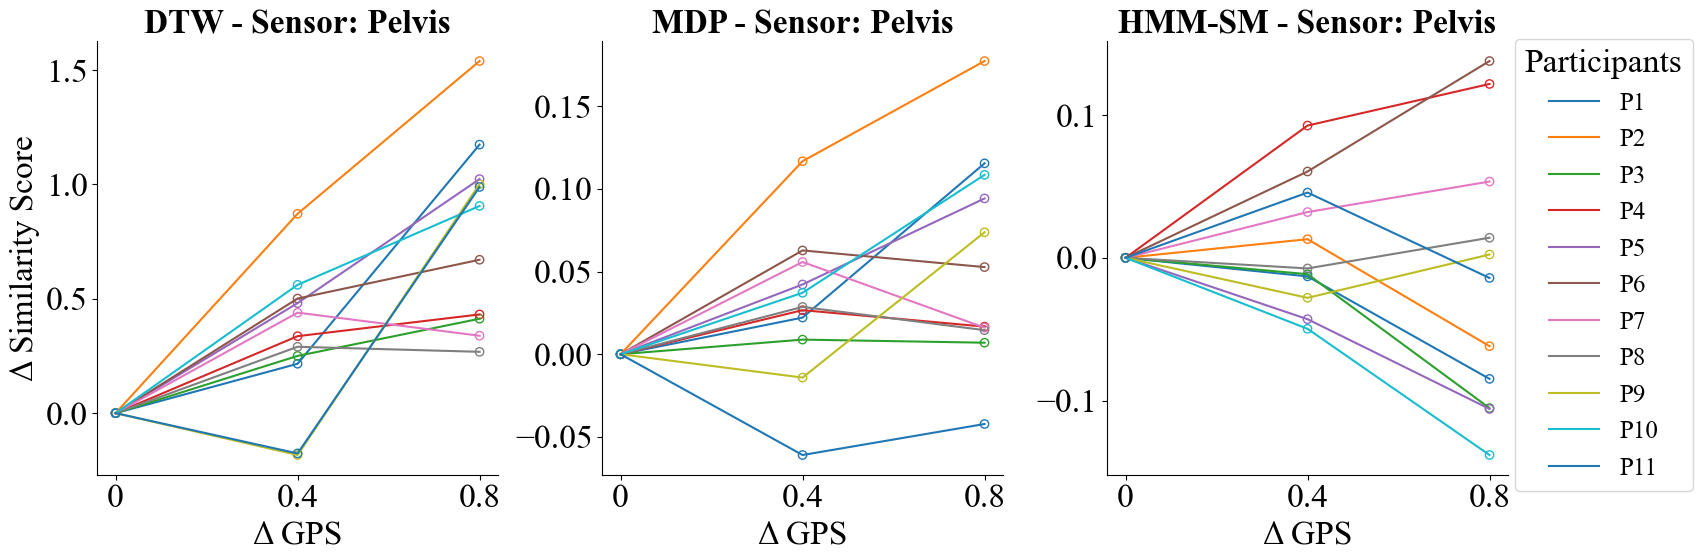

[0.0, 2.9249449200000015, 5.695778730000001]
[0.0, 2.6997921500000004, 5.420520780000004]
[0.0, 1.585341629999995, 3.319317749999996]
[0.0, -0.8274104400000084, 0.7379799999999932]
[0.0, 3.226285279999999, 4.25829714999999]
[0.0, 3.073006989999996, 3.9823752599999978]
[0.0, 4.61259407, 6.213534760000002]
[0.0, -0.9609120000000075, -0.3205102000000011]
[0.0, -0.5061842599999977, 2.520049]
[0.0, 0.08231551000000081, 1.834667060000001]
[0.0, -2.3428410200000016, -1.7746184000000014]
[0.0, 0.22291985599999986, 0.6211565649999997]
[0.0, 0.3780659310000001, 0.8086329359999995]
[0.0, 0.09182924700000017, 0.22548412800000017]
[0.0, -0.049568135000000346, 0.07635024399999946]
[0.0, 0.31169278700000014, 0.4866684560000003]
[0.0, 0.14162330200000017, 0.1636432069999998]
[0.0, 0.36583004200000024, 0.5727916309999999]
[0.0, -0.0452683029999994, -0.0013901429999991777]
[0.0, -0.09022613800000023, 0.23247690799999976]
[0.0, 0.07542296500000001, 0.2754072970000001]
[0.0, -0.2882412790000002, -0.474719

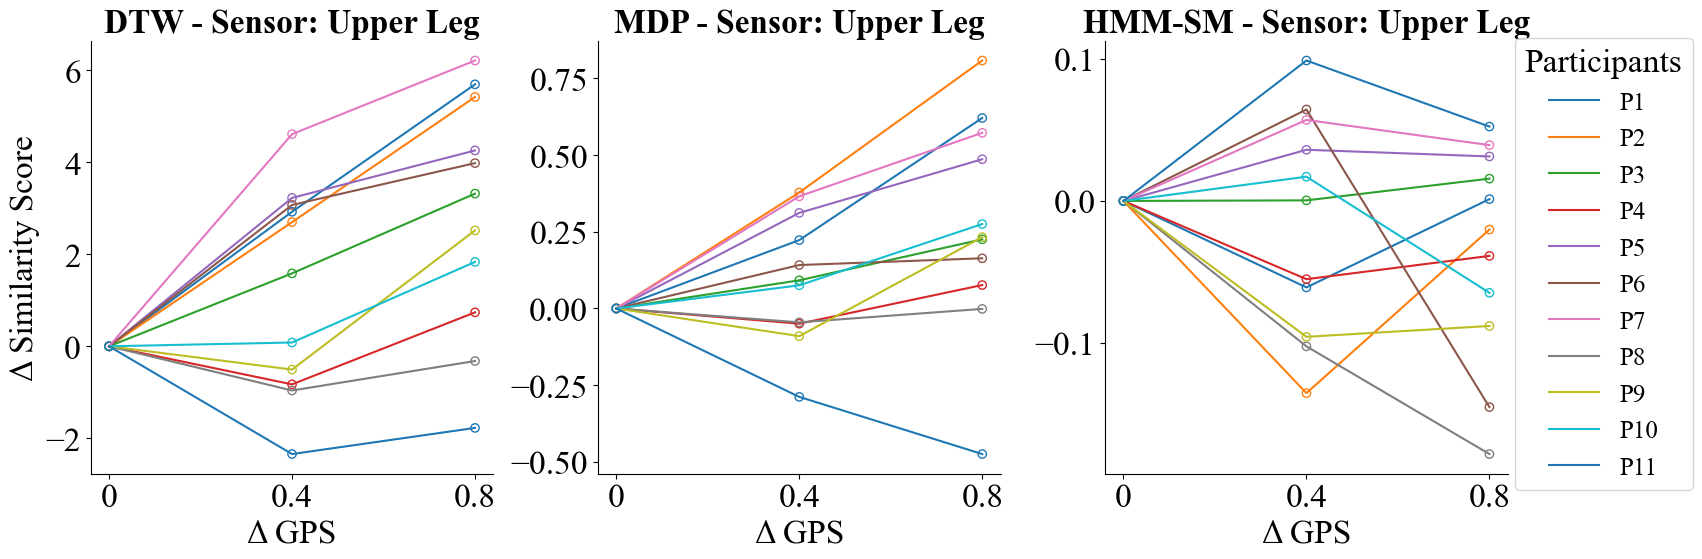

[0.0, 2.0185426600000014, 2.2789688300000037]
[0.0, 1.7654231400000029, 6.278772000000004]
[0.0, 3.148354210000001, 4.465183439999997]
[0.0, -0.7670748199999977, 1.6350596800000048]
[0.0, 1.9329556200000013, 3.4303062700000027]
[0.0, 2.3041358399999936, 3.106425829999999]
[0.0, 3.5190504199999992, 5.698329450000003]
[0.0, 0.4490209600000057, 2.673541270000001]
[0.0, -0.6860694100000018, 2.4707342999999966]
[0.0, 0.4220695000000063, 1.3728165200000007]
[0.0, -1.5505673400000006, 0.5263120600000022]
[0.0, 0.24679476499999975, 0.41917573100000016]
[0.0, 0.3250280939999999, 0.9645201819999998]
[0.0, 0.19279762099999997, 0.3707991919999998]
[0.0, -0.07577285599999994, 0.09561404200000023]
[0.0, 0.23957291400000003, 0.4641684810000002]
[0.0, 0.21958928099999975, 0.3450080899999999]
[0.0, 0.268922082, 0.5414298099999999]
[0.0, 0.06042920499999971, 0.3298088659999996]
[0.0, -0.03700591299999978, 0.36346265099999986]
[0.0, 0.0748400440000001, 0.29974867800000027]
[0.0, -0.22723314500000003, -0.

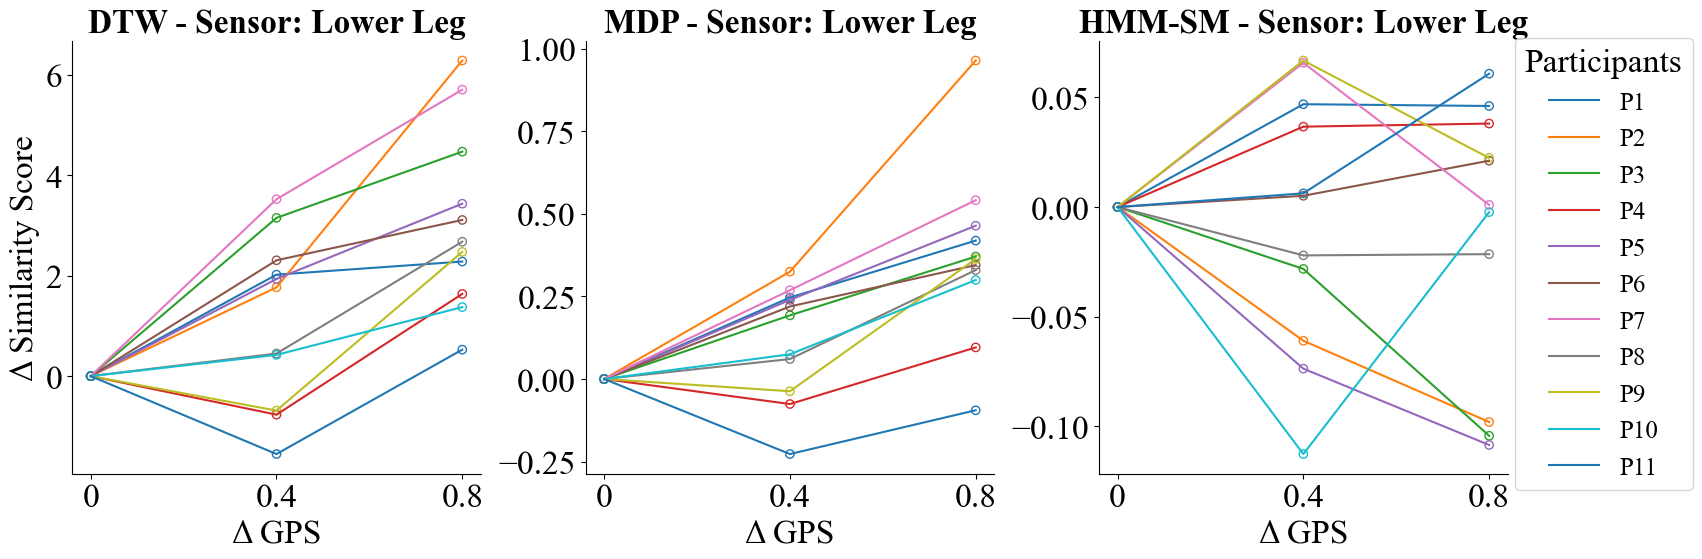

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\GPS_3algorithms\logresults_12-08-24_11-20_GPS.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

def calculate_srm(col1, col2):
    valid_indices = ~col1.isna() & ~col2.isna()
    if np.any(valid_indices):
        mean_diff = np.mean(col1[valid_indices] - col2[valid_indices])
        std_diff = np.std((col1[valid_indices] - col2[valid_indices]), ddof=1)
        return mean_diff / std_diff
    else:
        return np.nan

def calculate_cohens_d(group1, group2):
    mean_diff = mean(group1) - mean(group2)
    pooled_std = np.sqrt((stdev(group1)**2 + stdev(group2)**2) / 2)
    return mean_diff / pooled_std

# Function to plot scatter plots
def plot_scatter(data, sensor):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"

    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    
    algorithms = list(data['Algorithm'].unique())
    
    #Makes sure it is the last one 
    if "HMM-SM" in algorithms:
        algorithms.remove("HMM-SM")
        algorithms.append("HMM-SM")
        
    colorslist = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [colorslist[i % len(colorslist)] for i in range(11)]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        df_ydiff = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
                Y_diff = participant_data['Y_diff'].values.tolist()
                df.loc[i] = Y
                
                df_ydiff.loc[i] = participant_data['Y_diff']
                print(Y_diff)
                ax.plot(['0', '0.4', '0.8'], Y_diff, label=f"P{i+1}")
                ax.scatter(['0', '0.4', '0.8'], Y_diff, marker='o', edgecolors=colors[i], facecolors='none')
                #ax.set_ylim(bottom=0)
            ax.set_xlabel("Δ GPS", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=24)
            if idx == 0:
                ax.set_ylabel("Δ Similarity Score", fontsize=24)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=24, fontweight='bold')

    # Single legend outside the plot, but closer to the subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), title="Participants",fontsize=18,title_fontsize=24)
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust rect to leave space for the title and legend
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    
    plt.savefig(f"Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Manuscript\\Potential_Plots\\{sensor}_Scatter_GPS.svg", bbox_inches='tight')
    plt.show()

# Function to plot error bar plots
def plot_error_bars(data, sensor):
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    algorithms = list(data['Algorithm'].unique())
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                df.loc[i] = Y
                
            #print(df)
            mean_values = df.mean()
            #print(mean_values)
            sem_values = df.sem()
            x_labels = df.columns
            ax.errorbar(['0', '0.03', '0.06'], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o', capsize=5, color='black')
            ax.set_xlabel('Δ STSR', fontsize=14)
            ax.set_xticklabels()
            if idx == 0:
                ax.set_ylabel('Similarity', fontsize=14)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=14, fontweight='bold')
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    
    plt.savefig(f"Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Manuscript\\Potential_Plots\\{sensor}_ErrorBars_GPS.svg", bbox_inches='tight')
    plt.show()

sensors = data['Sensor'].unique()

# Plot for each sensor across all algorithms
for sensor in sensors:
    plot_scatter(data, sensor)
    #plot_error_bars(data, sensor)

In [86]:



import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations
import pingouin as pg
import os


t_test_results = {}
file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR_3aglorithms\logresults_12-08-24_11-40_STSR.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Function to perform paired t-tests and apply BH correction
def analysis_byalgorithm(data, algorithm, sensor):
    
    # Initialize DataFrame to hold data for each participant
    
    subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
    print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')
    df = pd.DataFrame(columns=['L0', 'L1','L2'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
    
    if not subset.empty:
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            if algorithm == "HMM-SM":
                participant_data = participant_data.iloc[1:] #Existing data also contains the BL-BL comparison (between trained models). Want to remove this.
            Y = participant_data['Y'].values.tolist()
            df.loc[i] = Y     
       
    # Drop participants with any missing data across the conditions
    df.dropna(inplace=True)
    print(df)
    if df.empty:
        print("No complete data available for paired t-tests.")
        return
    
    # List of columns (conditions) to compare
    columns = df.columns.tolist()
    
    # Generate all unique pairs of conditions
    pairs = list(combinations(columns, 2))
    
    # Exclude specific pairs if necessary
    #excluded_pairs = [('BL', 'L1'), ('BL', 'L2'),('BL', 'L0')]  # Exclude comparisons to the second baseline group
    filtered_pairs = [pair for pair in pairs]
    
    # Prepare lists to store p-values and their corresponding pairs
    p_values = []
    p_value_pairs = []
    t_test_results = {}
    
    # Perform paired t-tests using pingouin and calculate SRM
    for col1, col2 in filtered_pairs:
        data1 = df[col1].astype(float)
        data2 = df[col2].astype(float)
        
        
        # Calculate SRM
        difference = data1 - data2
        mean_diff = np.mean(difference)
        std_diff = np.std(difference, ddof=1)
        srm = mean_diff / std_diff if std_diff != 0 else np.nan
        normality_res = pg.normality(difference)
        p_normality = normality_res['pval'].values[0]
        
        if p_normality > 0.05:
            print("Data is normally distributed")
            pair_name = f'{col1}_vs_{col2}'
            # Perform paired t-test
            ttest_res = pg.ttest(data1, data2, paired=True)
            t_stat = ttest_res['T'].values[0]
            p_val = ttest_res['p-val'].values[0]
            t_test_results[pair_name] = {'t_statistic': t_stat, 'p_value': p_val, 'srm': srm}
        else:
            print("Data is not normally distributed")
            pair_name = f'{col1}_vs_{col2}'
            ttest_res = pg.ttest(data1, data2, paired=True)
            t_stat = ttest_res['T'].values[0]
            p_val = ttest_res['p-val'].values[0]
            t_test_results[pair_name] = {'t_statistic': t_stat, 'p_value': p_val, 'srm': srm}
        
        # Collect p-values for BH correction
        p_values.append(p_val)
        p_value_pairs.append(pair_name)
    
    # Apply Benjamini-Hochberg correction
    bh_results = pg.multicomp(p_values, method='fdr_bh')
    corrected_p_values = bh_results[1]
    
    # Map corrected p-values to their corresponding pairs
    corrected_p_value_mapping = dict(zip(p_value_pairs, corrected_p_values))
    
    # Display results
    for pair in t_test_results:
        t_stat = t_test_results[pair]['t_statistic']
        raw_p_val = t_test_results[pair]['p_value']
        corrected_p_val = corrected_p_value_mapping[pair]
        srm = t_test_results[pair]['srm']
        significance = 'Yes' if corrected_p_val < 0.05 else 'No'
        
        print(f"{pair}: t-statistic = {t_stat:.3f}, "
              f"p-value = {raw_p_val:.3f}, "
              f"BH-adjusted p-value = {corrected_p_val:.3f}, "
              f"SRM = {srm:.3f}, "
              f"Significant = {significance}")
    
    # Append t-test results to CSV
    csv_file2 = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR_3aglorithms\logresults_12-08-24_11-40_STSR_statistics.csv"
    if not os.path.exists(csv_file2):
        with open(csv_file2, "w") as file:
            file.write("Algorithm,Sensor,Comparison,T-statistic,Raw p-value,BH-adjusted p-value,SRM\n")
            
    # Prepare data for CSV
    with open(csv_file2, "a") as file:
        for pair in t_test_results:
            t_stat = t_test_results[pair]['t_statistic']
            raw_p_val = t_test_results[pair]['p_value']
            corrected_p_val = corrected_p_value_mapping[pair]
            srm = t_test_results[pair]['srm']
            if not os.path.exists(csv_file2):
                file.write(f"{algorithm}, {sensor}, {pair}, {t_stat}, {raw_p_val}, {corrected_p_val}, {srm}\n")
    
    print(f"Results appended to {csv_file2}")

# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Perform analysis for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        analysis_byalgorithm(data, algorithm, sensor)


Generating results for DTW, pelvis, number of data points: 33
           L0         L1         L2
0   16.656152  14.183787  15.455387
1   15.847926  16.258878  16.518701
2    9.598217   9.746951   9.960269
3   12.945984  13.137598  13.476664
4   17.468089  17.749108  18.311471
5   17.447727  17.503878  17.706541
6   11.616933  11.929156  12.596861
7   12.558699  12.682313  13.628388
8   12.455639  11.935265  11.873419
9   15.516103  15.793368  15.448621
10  15.948184  15.836319  15.940409
Data is not normally distributed
Data is normally distributed
Data is normally distributed
L0_vs_L1: t-statistic = 0.479, p-value = 0.643, BH-adjusted p-value = 0.643, SRM = 0.144, Significant = No
L0_vs_L2: t-statistic = -1.245, p-value = 0.242, BH-adjusted p-value = 0.362, SRM = -0.375, Significant = No
L1_vs_L2: t-statistic = -2.735, p-value = 0.021, BH-adjusted p-value = 0.063, SRM = -0.825, Significant = No
Results appended to Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Result

In [92]:
""" T-test, benjamini-hochberg correction and SRM for each comparison level"""
import numpy as np
import pandas as pd
import pingouin as pg
import os
from itertools import combinations

# Function to calculate SRM
def calculate_srm(data1, data2):
    difference = data1 - data2
    mean_diff = np.mean(difference)
    std_diff = np.std(difference, ddof=1)
    return mean_diff / std_diff if std_diff != 0 else np.nan

# Reading the data
file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR_3aglorithms\logresults_12-08-24_11-40_STSR.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Function to perform pairwise tests using pingouin's pairwise_tests and save results to CSV
def analysis_byalgorithm(data, algorithm, sensor, parametric=True, correction='fdr_bh'):
    subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
    print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')

    # Prepare the DataFrame with the relevant data for pairwise comparisons
    df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
    
    if not subset.empty:
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            if algorithm == "HMM-SM":
                participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
            Y = participant_data['Y'].values.tolist()
            df.loc[i] = Y

    # Drop participants with any missing data across the conditions
    df.dropna(inplace=True)

    if df.empty:
        print("No complete data available for pairwise comparisons.")
        return
    print(df)
    # Reshape DataFrame for pairwise comparison
    df_melted = df.reset_index().melt(id_vars=['index'], var_name='Level', value_name='Y')
    df_melted.rename(columns={'index': 'Participant'}, inplace=True)
    df_melted['Y'] = pd.to_numeric(df_melted['Y'], errors='coerce')
    df_melted.dropna(subset=['Y'], inplace=True)

    # Perform pairwise comparisons using pingouin
    results = pg.pairwise_tests(
        dv='Y', 
        within='Level', 
        subject='Participant', 
        data=df_melted, 
        parametric=parametric, 
        padjust=correction, 
        effsize='cohen'
    )

    # Calculate SRM for each comparison
    srm_values = {}
    normality = {}
    levels = ['L0', 'L1', 'L2']
    pairs = list(combinations(levels, 2))
    for level1, level2 in pairs:
        data1 = df[df.columns[df.columns.get_loc(level1)]].astype(float)
        data2 = df[df.columns[df.columns.get_loc(level2)]].astype(float)
        if not data1.empty and not data2.empty:
            difference = data1 - data2
            mean_diff = np.mean(difference)
            std_diff = np.std(difference, ddof=1)
            srm =  mean_diff / std_diff if std_diff != 0 else np.nan
            srm_values[f'{level1}_vs_{level2}'] = srm
            
            normality_res = pg.normality(difference)
            p_normality = normality_res['pval'].values[0]
        
            if p_normality > 0.05:
                normality_value = True
            else:
                normality_value = p_normality
            normality[f'{level1}_vs_{level2}'] = normality_value
        else:
            print(f"Data for {level1} or {level2} is empty.")
            srm_values[f'{level1}_vs_{level2}'] = np.nan


    # Add sensor and algorithm columns to the results
    results['Sensor'] = sensor
    results['Algorithm'] = algorithm

    # Add SRM to the results DataFrame
    results['SRM'] = results.apply(lambda row: srm_values.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)
    results['Normality'] = results.apply(lambda row: normality.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)
    # Reorder columns to make 'Sensor' and 'Algorithm' the leftmost columns
    results = results[['Sensor', 'Algorithm'] + [col for col in results.columns if col not in ['Sensor', 'Algorithm']]]

    # # File path for the CSV
    # #csv_file2 = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR_3aglorithms\STSR_PairwiseTests.csv"
    # # Write header if the file does not exist
    # if not os.path.exists(csv_file2):
    #     results.to_csv(csv_file2, index=False)
    # else:
    #     results.to_csv(csv_file2, mode='a', header=False, index=False)

    # print(f"Results appended to {csv_file2}")

# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Perform analysis for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        analysis_byalgorithm(data, algorithm, sensor, parametric=False, correction='fdr_bh')  # Set parametric to True or False as needed

Generating results for DTW, pelvis, number of data points: 33
           L0         L1         L2
0   16.656152  14.183787  15.455387
1   15.847926  16.258878  16.518701
2    9.598217   9.746951   9.960269
3   12.945984  13.137598  13.476664
4   17.468089  17.749108  18.311471
5   17.447727  17.503878  17.706541
6   11.616933  11.929156  12.596861
7   12.558699  12.682313  13.628388
8   12.455639  11.935265  11.873419
9   15.516103  15.793368  15.448621
10  15.948184  15.836319  15.940409
Generating results for HMM-SM, pelvis, number of data points: 44
          L0        L1        L2
0   0.514365  0.521442  0.533944
1   0.656646  0.673107  0.592234
2   0.622605  0.586216  0.621311
3   0.771457  0.804704  0.786786
4   0.625555  0.605068  0.618123
5   0.762806  0.761615   0.76494
6   0.623787  0.525624  0.612394
7   0.553043  0.610586  0.623643
8   0.585974  0.685443  0.655634
9    0.59416  0.687345   0.59263
10  0.625236  0.627396  0.454907
Generating results for MDP, pelvis, number of